In [75]:
## import all the necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
from scipy import stats
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_absolute_error
import datetime as dt
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from datetime import datetime

# 1. Business Problem

<b>Description</b>

Walmart is an American multinational retail corporation that operates a chain of hypermarkets headquartered in Arkansas, U.S. This project aims to predict weekly store sales using the historical sales data of 45 stores. 


<b>Why are we performing sales forecasting for Walmart?</b>

Sales forecasting helps revenue teams achieve their goals by identifying early warning signals in their pipeline and course-correcting before it’s too late. It allows companies to efficiently allocate resources for future growth and manage its cash flow and helps businesses estimate their costs and revenue accurately based on which they are able to predict their short-term and long-term performance.

<b>Machine Learning and Sales Forecasting</b>


Machine learning in sales forecasting is the process of training a model to take, learn how each input contributes to a weighted output, and use the model to predict outcomes based on previously unseen and real-time performance data. There is not clear cut pattern humans have set for buying and selling,however backing up the datasets spanning years into the past it's highly possible to draw patterns in sales and consumption.Machine learning becomes prominent here because of its ability to mine through years of data to detect patterns and repetitive behaviour, which can then be leveraged to forecast sales and demand.


# 2. Machine Learning problem

## 2.1 Data
## 2.1.1 Data Overview

Data was collected from year  2010 - 2012 for 45 Walmart stores. Main goal is to predict department sales for each store.
We are provided with datasets : Stores.csv,train.csv,test.csv,fetaures.csv

## Dataset Size

Trainset : 421570 rows (12.2MB)<br>
Testset :  115064 rows (2.47MB)<br>
Stores.csv : 4KB <br>
features.csv: 580 KB

## Column Descriptions
<b>Stores:<b/><br>

Type: Type of the store namely "A","B","C"<br>
Size: Size refers to the number of products inside the store . Range 34000 -210,000<br>
Store - The store number. Range 1- 45.<br>
Dept - One of 1–99 that shows the department<br>
Date - date of the week<br>
Weekly_Sales - sales for the given department in the given store<br>
IsHoliday - whether the week is a special holiday week.<br>

<b>Features:<b/><br>

Temperature - Average temperature in the region during that week<br>
Fuel_Price - cost of fuel in the region during that week<br>
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
represents what quantity was available during that week. Type is from 1 - 5.<br>
CPI - the consumer price index during that week.<br>
Unemployment - the unemployment rate during that week<br>

# 2.2 Mapping the real-world problem to a Machine Learning Problem

## 2.2.1 Type of Machine Learning Problem

It's a regression problem where we are given time series(from 05-02-2010 to 26-10-2012) data with multiple categorical and numerical features.We are tasked to predict department wise sales of each store from 02-11-2012 to 26-07-2013 . In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data

# 3. EXPLORATORY DATA ANALYSIS

## 3.1 DATA LOADING

In [2]:
### loading our trainset and test set 
trainset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")
featureset = pd.read_csv("features.csv")
storeset = pd.read_csv("stores.csv")

In [3]:
## Check number of rows and columns
print("Shape of trainset: ",trainset.shape)
print("Shape of testset: ",testset.shape)

Shape of trainset:  (421570, 5)
Shape of testset:  (115064, 4)


## 3.2 Identifying Variables and data types

In [4]:
### Check field names of all the columns
print("Field name in trainset ",trainset.columns)
print("\n")
print("*"*100)
print("Field name in featureset ",featureset.columns)
print("\n")
print("*"*100)
print("Field name in storeset ",storeset.columns)
print("\n")
print("*"*100)

Field name in trainset  Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')


****************************************************************************************************
Field name in featureset  Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


****************************************************************************************************
Field name in storeset  Index(['Store', 'Type', 'Size'], dtype='object')


****************************************************************************************************


In [5]:
## let's check the dtypes of the columns
trainset.dtypes.to_frame().rename(columns={0:"Datatype"})

,Datatype
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday,bool


We can see that the date field is in string format lets convert to datetime using pandas to_datetime feature.

# 3.3 Treating missing values and duplicates

How null values can affect our data ?
Missing values are a common occurence in data. Most predictive modelling can not handle missing values therefore it has to be addressed before data modelling can be intiated otherwise problems such as value error will arise while performing data modelling. 

In [6]:
## lets check missing values in our Store set 
print('Number of unique values in Store = ',storeset.nunique())
print('*'*50)
print('Null values check in Store :')
print(storeset.apply(lambda x: sum(x.isnull()),axis=0))
## lets check missing values in our feature set 
print('*'*50)
print('Unique values in feature:',featureset.nunique())
print('*'*50)
print('Null values check in Feature :')
print(featureset.apply(lambda x: sum(x.isnull()),axis=0))
## lets check missing values in our trainset 
print('*'*50)
print('Unique values in train:',trainset.nunique())
print('*'*50)
print('Null values check in train :')
print(trainset.apply(lambda x: sum(x.isnull()),axis=0))
## lets check missing values in our testset 
print('*'*50)
print('Unique values in test:',testset.nunique())
print('*'*50)
print('Null values check in test :')
print(testset.apply(lambda x: sum(x.isnull()),axis=0))

Number of unique values in Store =  Store    45
Type      3
Size     40
dtype: int64
**************************************************
Null values check in Store :
Store    0
Type     0
Size     0
dtype: int64
**************************************************
Unique values in feature: Store             45
Date             182
Temperature     4178
Fuel_Price      1011
MarkDown1       4023
MarkDown2       2715
MarkDown3       2885
MarkDown4       3405
MarkDown5       4045
CPI             2505
Unemployment     404
IsHoliday          2
dtype: int64
**************************************************
Null values check in Feature :
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
**************************************************
Unique values in train: Store               45
De

CPI, Unemployment and Markdown have null values and we can replace them with mean.

In [7]:
## Number of unique stores and number unique deptartments in trainset
ustore = sorted(trainset.Store.unique())  ## unique stores list
udept = sorted(trainset.Dept.unique()) ## unique department list
udates = sorted(trainset.Date.unique()) ## unique date list
print('Total number of unique store and department and date set is ',len(ustore)*len(udept)*len(udates))

Total number of unique store and department and date set is  521235


In [8]:
print('Our trainset has store department combination of size :',len(trainset.groupby(['Store','Dept','Date']).count()))

Our trainset has store department combination of size : 421570


We see that few stores have missing departments and dates and their reported weekly sales !! We will mark their weekly sales as 0 and 'ISholiday' column as False

We can merge all the different fields from stores,features,train,test to one detailed dataset which contains all the field before performing the analysis,so that it's becomes handy in analysis.As we can observe that "Store" field is common in stores and features set we can perform a merge operation on "store" field and then merge it to the train set using three common fields (i.e) "Stores,Date,IsHoliday"

As we can see other than markdown cell no field has missing values in them.Let's calculate the % of null values in them

In [9]:
print("% of missing value in Markdown1: ",len(featureset[featureset.MarkDown1.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown2: ",len(featureset[featureset.MarkDown2.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown3: ",len(featureset[featureset.MarkDown3.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown4: ",len(featureset[featureset.MarkDown4.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown5: ",len(featureset[featureset.MarkDown5.isnull() == True])/len(featureset) * 100,"%")

% of missing value in Markdown1:  50.76923076923077 %
% of missing value in Markdown2:  64.33455433455434 %
% of missing value in Markdown3:  55.885225885225886 %
% of missing value in Markdown4:  57.7045177045177 %
% of missing value in Markdown5:  50.54945054945055 %


If there are more than 75% of null values we will drop the column as we can't even retain 75% information from them.
If there are less than 75% of null values we will perform imputation such as replacing with mean value per store

Data preparation for Analysis
We are going to clean our featureset,train and test set
Impute missing values in columns CPI,Unemployment with rolling averages and mean for markdown columns
Generate new rows for missing store ,dept combos with weekly sales as 0
merge all the dataset and prepare final clean datset

In [10]:
def clean_feature_(feature):
    ## Lets fill the nan values in CPI and unemployment with rolling mean of window size= 20  for every store and dept.
    print('Filling Null values in CPI and Unemployment with rolling averages ........')
    print('\n')
    for store in range(1,46) :
        values = feature[feature.Store == store].set_index('Date')
        feature.loc[(feature.Store == store),['CPI']] = np.array(values.CPI.fillna(values.CPI.rolling(20,min_periods=1).mean()))
        feature.loc[(feature.Store == store),['Unemployment']] = np.array(values.Unemployment.fillna(values.Unemployment.rolling(20,min_periods=1).mean()))
    
    ## let's fill markdown nan values with mean value in each store
    print('Filling Null values in Markdown with mean values in each store ........')
    print('\n')
    grp = feature.groupby('Store')
    for i in range(1,46):
        feature.loc[(feature.Store==i)&(feature.MarkDown1.isnull()==True),['MarkDown1']]= grp.MarkDown1.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown2.isnull()==True),['MarkDown2']]= grp.MarkDown2.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown3.isnull()==True),['MarkDown3']]= grp.MarkDown3.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown4.isnull()==True),['MarkDown4']]= grp.MarkDown4.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown5.isnull()==True),['MarkDown5']]= grp.MarkDown5.mean()[i]

    print('\n Null values computed for feature set ....................')  
    ### Recheck null values in feature
    print('Null values recheck in Feature :')
    print(feature.apply(lambda x: sum(x.isnull()),axis=0))
    return feature



In [11]:
### preparing sets
clean_feature_(featureset)

Filling Null values in CPI and Unemployment with rolling averages ........


Filling Null values in Markdown with mean values in each store ........



 Null values computed for feature set ....................
Null values recheck in Feature :
Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106000,False
1,1,2010-02-12,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.242170,8.106000,True
2,1,2010-02-19,39.93,2.514,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.289143,8.106000,False
3,1,2010-02-26,46.63,2.561,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.319643,8.106000,False
4,1,2010-03-05,46.50,2.625,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.350143,8.106000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.290000,975.030000,3.000000,2449.970000,3169.690000,193.336595,8.519545,False
8186,45,2013-07-05,77.50,3.614,9090.480000,2268.580000,582.740000,5797.470000,1514.930000,193.375908,8.509000,False
8187,45,2013-07-12,79.37,3.614,3789.940000,1827.310000,85.720000,744.840000,2150.360000,193.414029,8.496111,False
8188,45,2013-07-19,82.84,3.737,2961.490000,1047.070000,204.190000,363.000000,1059.460000,193.450510,8.480000,False


In [12]:
featureset.head(10)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.350143,8.106,False
5,1,2010-03-12,57.79,2.667,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.380643,8.106,False
6,1,2010-03-19,54.58,2.720,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.215635,8.106,False
7,1,2010-03-26,51.45,2.732,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.018042,8.106,False
8,1,2010-04-02,62.27,2.719,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,210.820450,7.808,False
9,1,2010-04-09,65.86,2.770,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,210.622857,7.808,False


In [13]:
df_wal=trainset.merge(featureset, on=['Store', 'Date'], how='inner').merge(storeset, on=['Store'], how='inner')
df_wal.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,False,A,151315


In [14]:
print(df_wal.apply(lambda x: sum(x.isnull()),axis=0))

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64


In [15]:
duplicates = len(df_wal[df_wal.duplicated(subset=['Store',"Dept",'Date'])])
print("Does the datset contain duplicate values : ",bool(duplicates))

Does the datset contain duplicate values :  False


# 3.4 Analysis on the target column 'Weekly Sales" !!

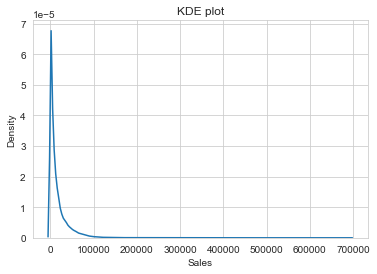

In [16]:
### Let's check the distribution of the weekly sales
x=df_wal[df_wal['Weekly_Sales']>0]['Weekly_Sales'] #x~N(0,1)
sns.set_style('whitegrid')
sns.kdeplot(np.array(x))
plt.title('KDE plot')
plt.xlabel('Sales')
plt.show()


The distribution is Powerlaw

In [17]:
#calculating total fare amount values at each percentile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = df_wal["Weekly_Sales"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -4988.94
10 percentile value is 291.1
20 percentile value is 1341.0
30 percentile value is 2913.39
40 percentile value is 4887.96
50 percentile value is 7612.03
60 percentile value is 11274.71
70 percentile value is 16619.5
80 percentile value is 25217.7
90 percentile value is 42846.96
100 percentile value is  693099.36


We see negative weekly sales reported values in the dataset!! Weekly Sales cannot be negative!


In [73]:
print('Number of rows which has negative sales reported == ',len(df_wal.loc[df_wal['Weekly_Sales']<0]))

Number of rows which has negative sales reported ==  0


Transform negatively reported sales to 0

In [19]:
df_wal.loc[df_wal['Weekly_Sales']<0,'Weekly_Sales'] = 0 

In [72]:
print('Number of negative sales now in set!!',len(df_wal.loc[df_wal['Weekly_Sales']<0]))

Number of negative sales now in set!! 0


In [21]:
### Check time series with all 0 weekly sales values!!
grp = df_wal.groupby(['Store','Dept'])['Weekly_Sales'].sum()
#print('Number of time series with all zero sales == ',len(grp[grp==0]))
store_dept_with_all_zeros_sales = list(grp[grp==0].index)
store_dept_with_all_zeros_sales

[(15, 37),
 (25, 96),
 (35, 19),
 (36, 36),
 (36, 71),
 (43, 55),
 (44, 34),
 (44, 71)]

In [22]:
## reset the index 
df_wal = df_wal.reset_index(drop=True)
for i,j in  store_dept_with_all_zeros_sales:
     df_wal.drop(df_wal[(df_wal.Store == i) & (df_wal.Dept == j)].index ,inplace=True)

In [23]:
print('Total number of rows  deleted == ',182 * len(store_dept_with_all_zeros_sales))
print('Length of train and test after deletion ==',len(df_wal))

Total number of rows  deleted ==  1456
Length of train and test after deletion == 421551


In [24]:
df_wal.drop('IsHoliday_y',axis=1,inplace=True)
df_wal.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,A,151315


In [25]:
df_wal.rename(columns={'IsHoliday_x':'Holiday','Temperature':'Temperature(C)','Fuel_Price':'Fuel_Price($USD/L)'},inplace=True)
df_wal.head(2)

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature(C),Fuel_Price($USD/L),MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.096358,8.106,A,151315


In [26]:
df_wal.shape

(421551, 16)

In [27]:
df_wal.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421551.0,22.199931,12.785176,1.000,11.000000,22.000000,33.000000,45.000000
Dept,421551.0,44.260576,30.492264,1.000,18.000000,37.000000,74.000000,99.000000
Weekly_Sales,421551.0,15982.187561,22711.290809,0.000,2080.010000,7612.920000,20206.365000,693099.360000
Temperature(C),421551.0,60.090073,18.447985,-2.060,46.680000,62.090000,74.280000,100.140000
Fuel_Price($USD/L),421551.0,3.361017,0.458518,2.472,2.933000,3.452000,3.738000,4.468000
MarkDown1,421551.0,7363.708286,5752.273932,0.270,3343.000000,7840.701111,10395.811778,88646.760000
MarkDown2,421551.0,3189.161781,5092.629568,-265.760,446.920000,2906.032286,4330.700000,104519.540000
MarkDown3,421551.0,1626.517428,5544.500842,-29.100,21.493188,1237.875698,2053.183596,141630.610000
MarkDown4,421551.0,3032.743843,3876.920036,0.220,865.090000,2445.655778,4305.263444,67474.850000
MarkDown5,421551.0,4441.040984,4305.306295,135.160,2309.980000,3635.082667,5047.069222,108519.280000


Analyse each store and their respective department weekly sales and find out if there is any incorrect data

In [28]:
df_store_sales=pd.pivot_table(df_wal,index='Store',columns='Dept', values='Weekly_Sales',aggfunc=np.mean)
display(df_store_sales)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4802.756713,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,480.584524
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.765734,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.465270,19340.693986,5985.671119,667.070315,30.235217,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.909304,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,373.757778,28.001429,NaN


# Date

In [29]:
df_wal['Date'].head(5).append(df_wal['Date'].tail(5))

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

The date is going from 2010-02-05 to 2012-10-26

# Holiday

In [30]:
#to see if all of the holidays are included in the data
df_holiday=df_wal.loc[df_wal['Holiday']==True]
df_holiday.Date.unique()


array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [31]:
# Super bowl dates
df_wal.loc[(df_wal['Date'] == '2010-02-12')|(df_wal['Date'] == '2011-02-11')|(df_wal['Date'] == '2012-02-10'),'Super_Bowl'] = True
df_wal.loc[(df_wal['Date'] != '2010-02-12')&(df_wal['Date'] != '2011-02-11')&(df_wal['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [32]:
df_wal[df_wal['Super_Bowl']==True].head(10)

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature(C),Fuel_Price($USD/L),MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl
73,1,1,2010-02-12,46039.49,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
74,1,2,2010-02-12,44682.74,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
75,1,3,2010-02-12,10887.84,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
76,1,4,2010-02-12,35351.21,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
77,1,5,2010-02-12,29620.81,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
78,1,6,2010-02-12,9135.00,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
79,1,7,2010-02-12,18310.31,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
80,1,8,2010-02-12,37334.83,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
81,1,9,2010-02-12,16562.49,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True
82,1,10,2010-02-12,31494.77,True,38.51,2.548,8536.592778,3346.401918,1670.797978,3653.631444,4428.307667,211.24217,8.106,A,151315,True


In [33]:
#LaborDay
df_wal.loc[(df_wal['Date']=='2010-09-10')|(df_wal['Date']=='2011-09-09')|(df_wal['Date']=='2012-09-07'),'LaborsDay']=True
df_wal.loc[(df_wal['Date']!='2010-09-10')&(df_wal['Date']!='2011-09-09')&(df_wal['Date']!='2012-09-07'),'LaborsDay']=False


In [34]:
#Thanksgiving
df_wal.loc[(df_wal['Date']=='2010-11-26')|(df_wal['Date']=='2011-11-25')|(df_wal['Date']=='2012-11-23'),'Thanksgiving']=True
df_wal.loc[(df_wal['Date']!='2010-11-26')&(df_wal['Date']!='2011-11-25')&(df_wal['Date']!='2012-11-23'),'Thanksgiving']=False

In [35]:
#Christmas
df_wal.loc[(df_wal['Date']=='2010-12-31')|(df_wal['Date']=='2011-12-30')|(df_wal['Date']=='2012-12-28'),'Christmas']=True
df_wal.loc[(df_wal['Date']!='2010-12-31')&(df_wal['Date']!='2011-12-30')&(df_wal['Date']!='2012-12-28'),'Christmas']=False

In [36]:
#Easters Day
df_wal.loc[(df_wal['Date']=='2010-04-04')|(df_wal['Date']=='2011-04-24')|(df_wal['Date']=='2012-04-08'), 'Easter']=True
df_wal.loc[(df_wal['Date']!='2010-04-04')|(df_wal['Date']!='2011-04-24')|(df_wal['Date']!='2012-04-08'), 'Easter']=False

In [37]:
df_wal.head(10)

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature(C),Fuel_Price($USD/L),MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,LaborsDay,Thanksgiving,Christmas,Easter
0,1,1,2010-02-05,24924.50,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
1,1,2,2010-02-05,50605.27,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
2,1,3,2010-02-05,13740.12,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
3,1,4,2010-02-05,39954.04,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
4,1,5,2010-02-05,32229.38,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
5,1,6,2010-02-05,5749.03,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
6,1,7,2010-02-05,21084.08,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
7,1,8,2010-02-05,40129.01,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
8,1,9,2010-02-05,16930.99,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False
9,1,10,2010-02-05,30721.50,False,42.31,2.572,8536.592778,3346.401918,1670.797978,...,4428.307667,211.096358,8.106,A,151315,False,False,False,False,False


In [38]:
def conditions(s):
    if s['Super_Bowl']==True:
        return 'Super_Bowl'
    elif s['LaborsDay'] == True:
        return 'LaborsDay'
    elif s['Thanksgiving']==True:
        return 'Thanksgiving'
    elif s['Christmas']==True:
        return 'Christmas'
    elif s['Easter']==True:
        return 'Easter'
    else:
        return 'No_Holiday'
df_wal['Holiday'] = df_wal.apply(conditions, axis=1)

In [93]:
def conditions(s):
    if s['Super_Bowl']==True:
        return True
    elif s['LaborsDay'] == True:
        return True
    elif s['Thanksgiving']==True:
        return True
    elif s['Christmas']==True:
        return True
    elif s['Easter']==True:
        return True
    else:
        return False
df_wal['IsHoliday'] = df_wal.apply(conditions, axis=1)

In [94]:
df_wal.head(10)

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature(C),Fuel_Price($USD/L),MarkDown1,MarkDown2,MarkDown3,...,Size,Super_Bowl,LaborsDay,Thanksgiving,Christmas,Easter,week,month,year,IsHoliday
0,1,1,2010-02-05,24924.50,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
1,1,2,2010-02-05,50605.27,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
2,1,3,2010-02-05,13740.12,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
3,1,4,2010-02-05,39954.04,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
4,1,5,2010-02-05,32229.38,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
5,1,6,2010-02-05,5749.03,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
6,1,7,2010-02-05,21084.08,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
7,1,8,2010-02-05,40129.01,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
8,1,9,2010-02-05,16930.99,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False
9,1,10,2010-02-05,30721.50,No_Holiday,42.31,2.572,8536.592778,3346.401918,1670.797978,...,151315,False,False,False,False,False,5,2,2010,False


In [40]:
df_wal[df_wal['Super_Bowl']==True]

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature(C),Fuel_Price($USD/L),MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,LaborsDay,Thanksgiving,Christmas,Easter
73,1,1,2010-02-12,46039.49,Super_Bowl,38.51,2.548,8536.592778,3346.401918,1670.797978,...,4428.307667,211.242170,8.106,A,151315,True,False,False,False,False
74,1,2,2010-02-12,44682.74,Super_Bowl,38.51,2.548,8536.592778,3346.401918,1670.797978,...,4428.307667,211.242170,8.106,A,151315,True,False,False,False,False
75,1,3,2010-02-12,10887.84,Super_Bowl,38.51,2.548,8536.592778,3346.401918,1670.797978,...,4428.307667,211.242170,8.106,A,151315,True,False,False,False,False
76,1,4,2010-02-12,35351.21,Super_Bowl,38.51,2.548,8536.592778,3346.401918,1670.797978,...,4428.307667,211.242170,8.106,A,151315,True,False,False,False,False
77,1,5,2010-02-12,29620.81,Super_Bowl,38.51,2.548,8536.592778,3346.401918,1670.797978,...,4428.307667,211.242170,8.106,A,151315,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419068,45,93,2012-02-10,2166.02,Super_Bowl,37.00,3.640,15760.300000,6113.950000,5.430000,...,4685.580000,189.707605,8.424,B,118221,True,False,False,False,False
419069,45,94,2012-02-10,4479.20,Super_Bowl,37.00,3.640,15760.300000,6113.950000,5.430000,...,4685.580000,189.707605,8.424,B,118221,True,False,False,False,False
419070,45,95,2012-02-10,53291.16,Super_Bowl,37.00,3.640,15760.300000,6113.950000,5.430000,...,4685.580000,189.707605,8.424,B,118221,True,False,False,False,False
419071,45,97,2012-02-10,6638.91,Super_Bowl,37.00,3.640,15760.300000,6113.950000,5.430000,...,4685.580000,189.707605,8.424,B,118221,True,False,False,False,False


<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

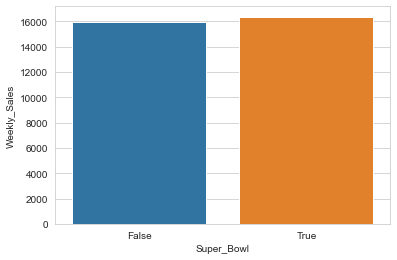

In [41]:

sns.barplot(data=df_wal,x='Super_Bowl',y='Weekly_Sales',ci=None)

<AxesSubplot:xlabel='LaborsDay', ylabel='Weekly_Sales'>

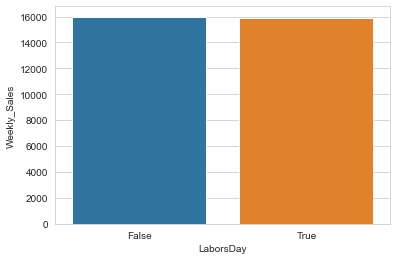

In [42]:


sns.barplot(data=df_wal,x='LaborsDay',y='Weekly_Sales',ci=None)

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

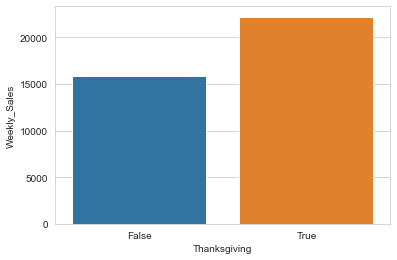

In [43]:
sns.barplot(data=df_wal,x='Thanksgiving',y='Weekly_Sales',ci=None)

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

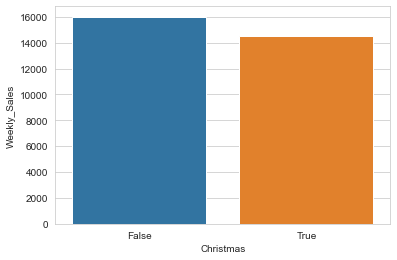

In [44]:
sns.barplot(data=df_wal,x='Christmas',y='Weekly_Sales',ci=None)

In [45]:
#Which holiday brings in the most weekly sales for walmart
#Holiday_sales=df_wal[(df_wal['Super_Bowl']==True)|(df_wal['Christmas']==True)|(df_wal['LaborsDay']==True)|(df_wal['Thanksgiving']==True)]

In [46]:
df_sales = df_wal.groupby(['Holiday']).agg(mean=("Weekly_Sales",'mean'))

df_sales = df_sales.reset_index()
df_sales.head(10)

,Holiday,mean
0,Christmas,14544.070187
1,LaborsDay,15881.912663
2,No_Holiday,15902.420612
3,Super_Bowl,16378.169039
4,Thanksgiving,22221.018981


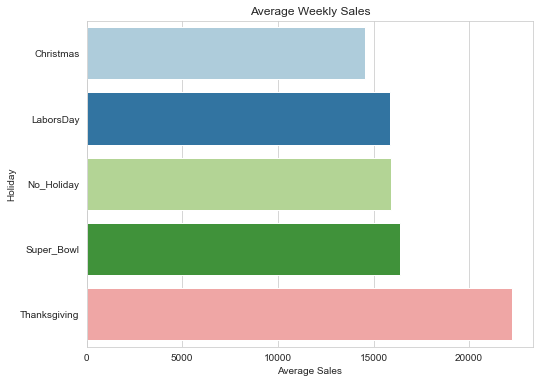

In [47]:
plt.figure(figsize=(8,6))
sns.set_palette("Paired")
sns.barplot(data=df_sales,y='Holiday',x='mean')
plt.xlabel('Average Sales')
plt.title('Average Weekly Sales');

# 3.5 Store Type, Department and Holidays


In [48]:
df_store=df_wal.groupby(['Type','Holiday'])['Weekly_Sales'].mean()
df_store.reset_index()

,Type,Holiday,Weekly_Sales
0,A,Christmas,18231.841711
1,A,LaborsDay,19973.464547
2,A,No_Holiday,20009.140877
3,A,Super_Bowl,20603.705079
4,A,Thanksgiving,27370.792324
5,B,Christmas,11394.448961
6,B,LaborsDay,12013.718750
7,B,No_Holiday,12154.275110
8,B,Super_Bowl,12402.140584
9,B,Thanksgiving,18661.330383


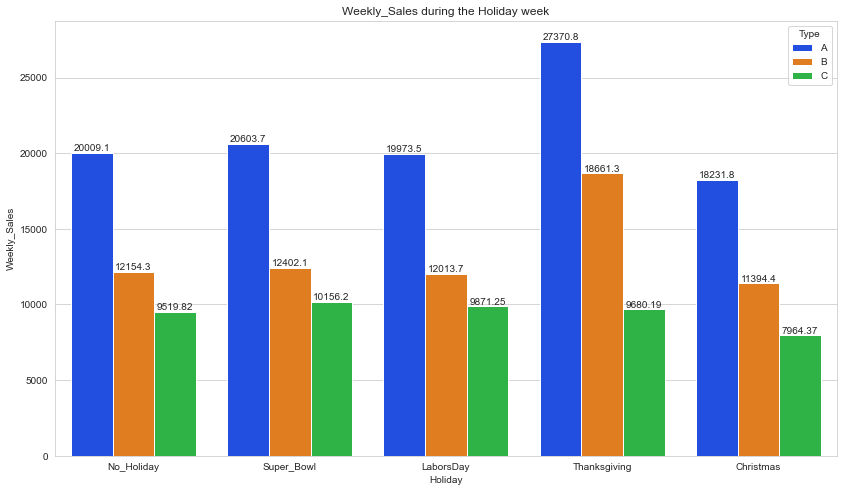

In [49]:
plt.figure(figsize=(14,8))
sns.set_palette("bright")
ax=sns.barplot(x = 'Holiday',
            y = 'Weekly_Sales',
            hue = 'Type',
            data = df_wal,ci=None)
plt.title('Weekly_Sales during the Holiday week')
ax.bar_label(ax.containers[0]) 
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
# Show the plot
plt.show()

<AxesSubplot:xlabel='Type', ylabel='Size'>

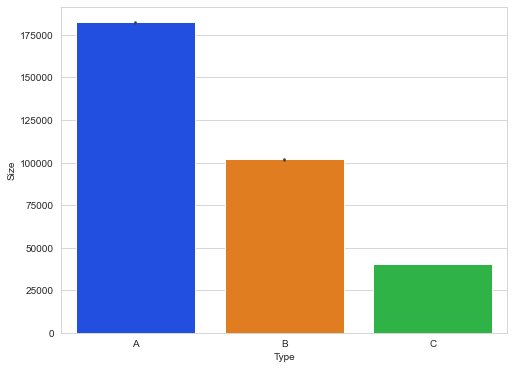

In [50]:
plt.figure(figsize=(8,6))
sns.barplot(x='Type',y='Size',data=df_wal)

<AxesSubplot:xlabel='Type', ylabel='Size'>

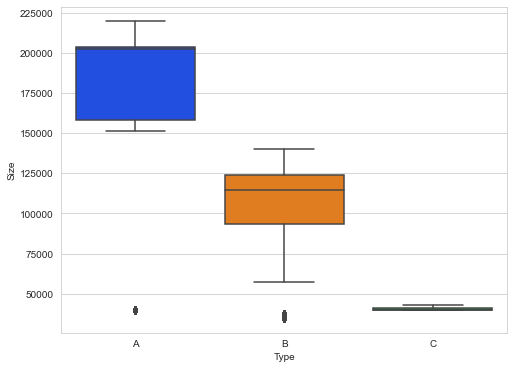

In [51]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Type',y='Size',data=df_wal)

In [77]:
## let's create two date features here week,year for analysis
df_wal['week'] = df_wal['Date'].dt.week
df_wal['year'] = df_wal['Date'].dt.year
sales_per_week_year =  df_wal.groupby(['Date','week','year'],as_index=False)['Weekly_Sales'].mean()

## Plotting mean sales over years(2010-2012)
## we are plotting using plotly library to get more readability   
fig = px.line(sales_per_week_year, y="Weekly_Sales",x='week',
              title='Mean Sales - per week over the years',color='year',line_group='year',)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(1,53) ,
        ticktext = np.arange(1,53)
    )
)
fig.show()

We can observe that during thanksgiving week and christmas week there is soaring peaks of sales.
Apart from that we can observe peaks during easter week i.e April 2,2010 , April 22 ,2011 and April 6,2012. However,these are not included as holiday weeks in our datasets.So we will include them as holiday week.

In [79]:
## Let's plot  sales per store
## Using Plotly we are creating pie chart !! Let's plot the mean sales for every week
sales_per_type =  df_wal.groupby(['Type'],as_index=False)['Weekly_Sales'].median()
fig = make_subplots(rows=1, cols=1,subplot_titles=['Type(Median)','Store(Median)'],
                   specs=[[{"type": "pie"}]])
fig.add_trace(go.Pie(labels=sales_per_type['Type'], values=sales_per_type['Weekly_Sales'],text=sales_per_type['Type']),row=1,col=1)
fig.show()

As observed from the pie-cart

From the plot we can see that store type "A" has the greatest sales

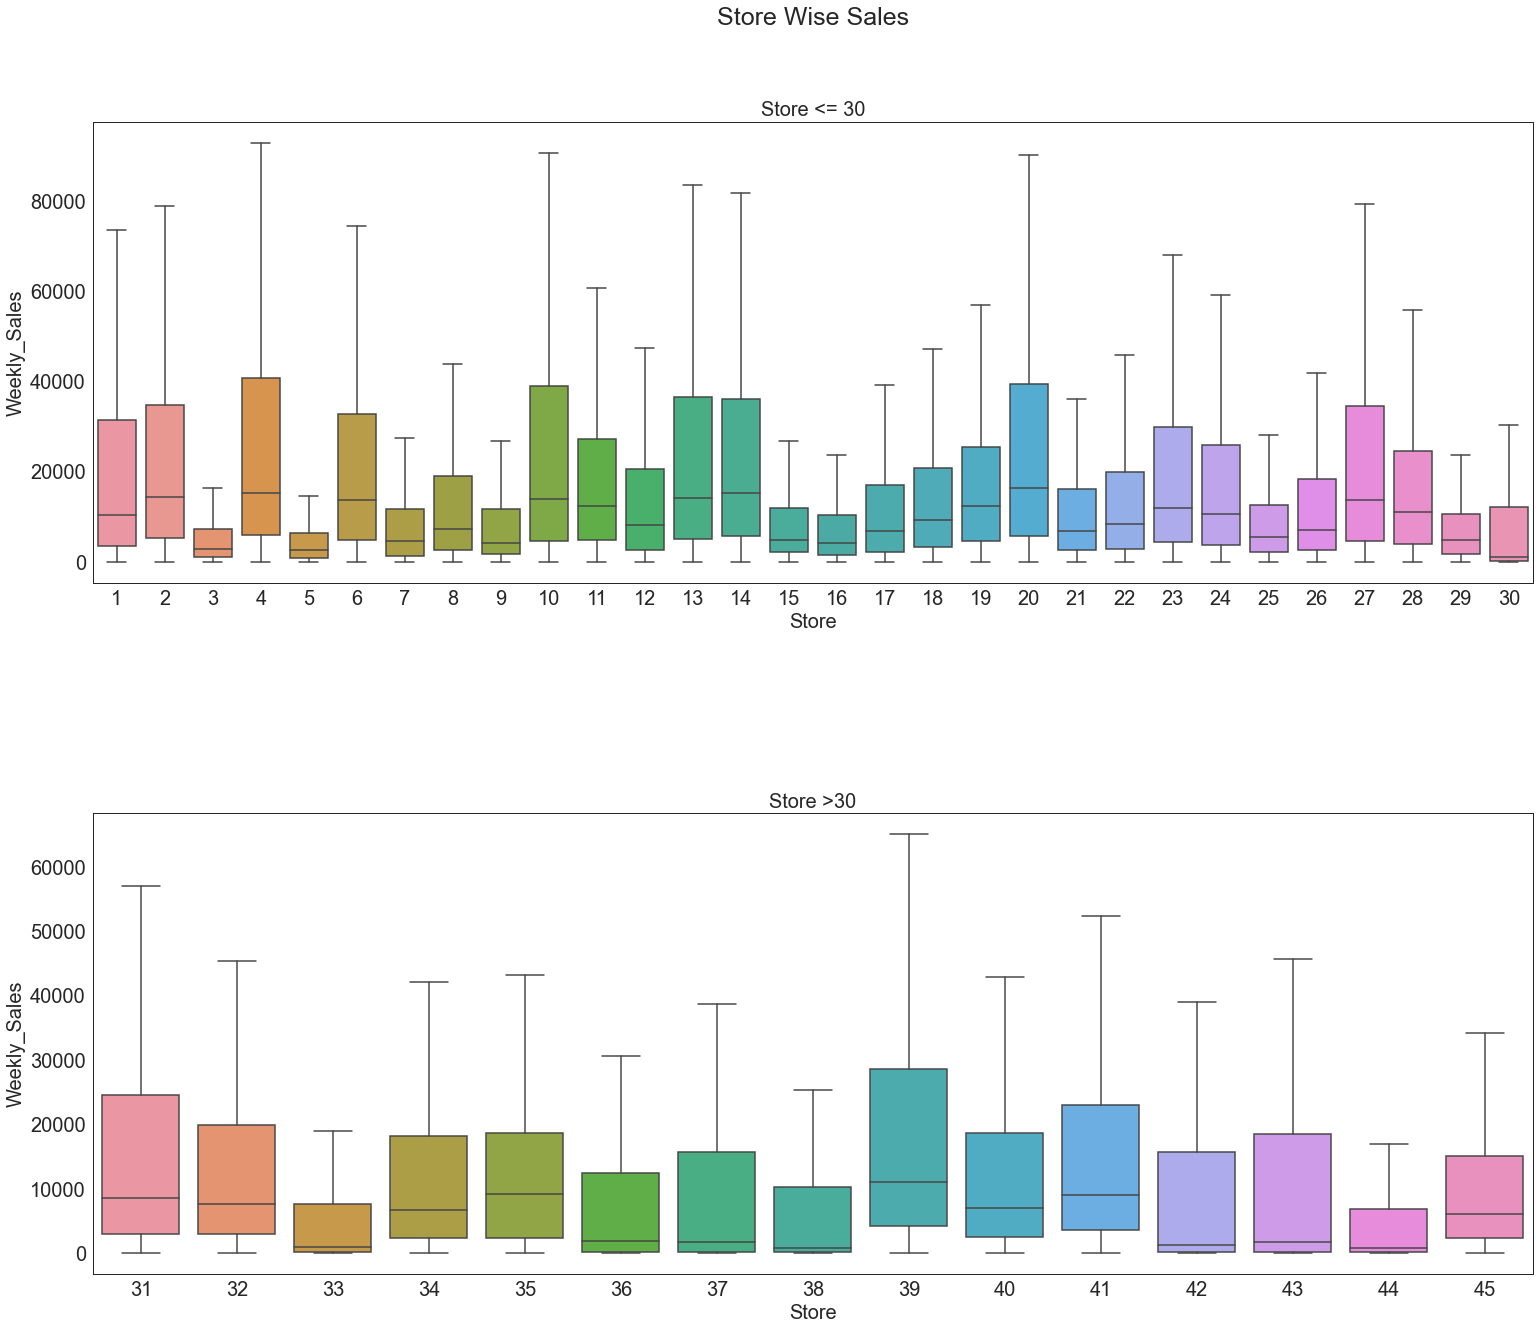

In [82]:
a=df_wal.query('Store <= 30' )
b=df_wal.query('Store >30 and Store <=60')
fig,axes = plt.subplots(2,1,figsize=(25,20)) 
fig.suptitle('Store Wise Sales',fontsize=25)

fig.subplots_adjust(wspace=0.5,hspace=0.5)
fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
### subplot for Store<30
sns.boxplot(x=a['Store'],y=a['Weekly_Sales'],showfliers=False,ax=axes[0])
axes[0].set_title('Store <= 30',fontsize=20)
axes[0].set_xlabel('Store',fontsize=20)
axes[0].set_ylabel('Weekly_Sales',fontsize=20)
axes[0].tick_params(labelsize=20)

### Store >30 
sns.boxplot(x=b['Store'],y=b['Weekly_Sales'],showfliers=False,ax=axes[1])
axes[1].set_title('Store >30',fontsize=20)
axes[1].set_xlabel('Store',fontsize=20)
axes[1].set_ylabel('Weekly_Sales',fontsize=20)
axes[1].tick_params(labelsize=20)

<b>Observations :<b><br>

Few stores show higher mean sales and higher interquartile range showing that some stores are bigger than others<br>

Some stores have their 25th and 50th percentile values very close and 75th percentile is far away showing that there is not much sales values difference between point below 25% and point below 50%<br>

Theory : We can understand that the stores with the higher weekly sales(1,2,4,10...) can be categorized as type 'A' stores with medium sales as type 'B'(11,2,19,20...) and the rest as type 'C'(3,5,29,30...)<br>


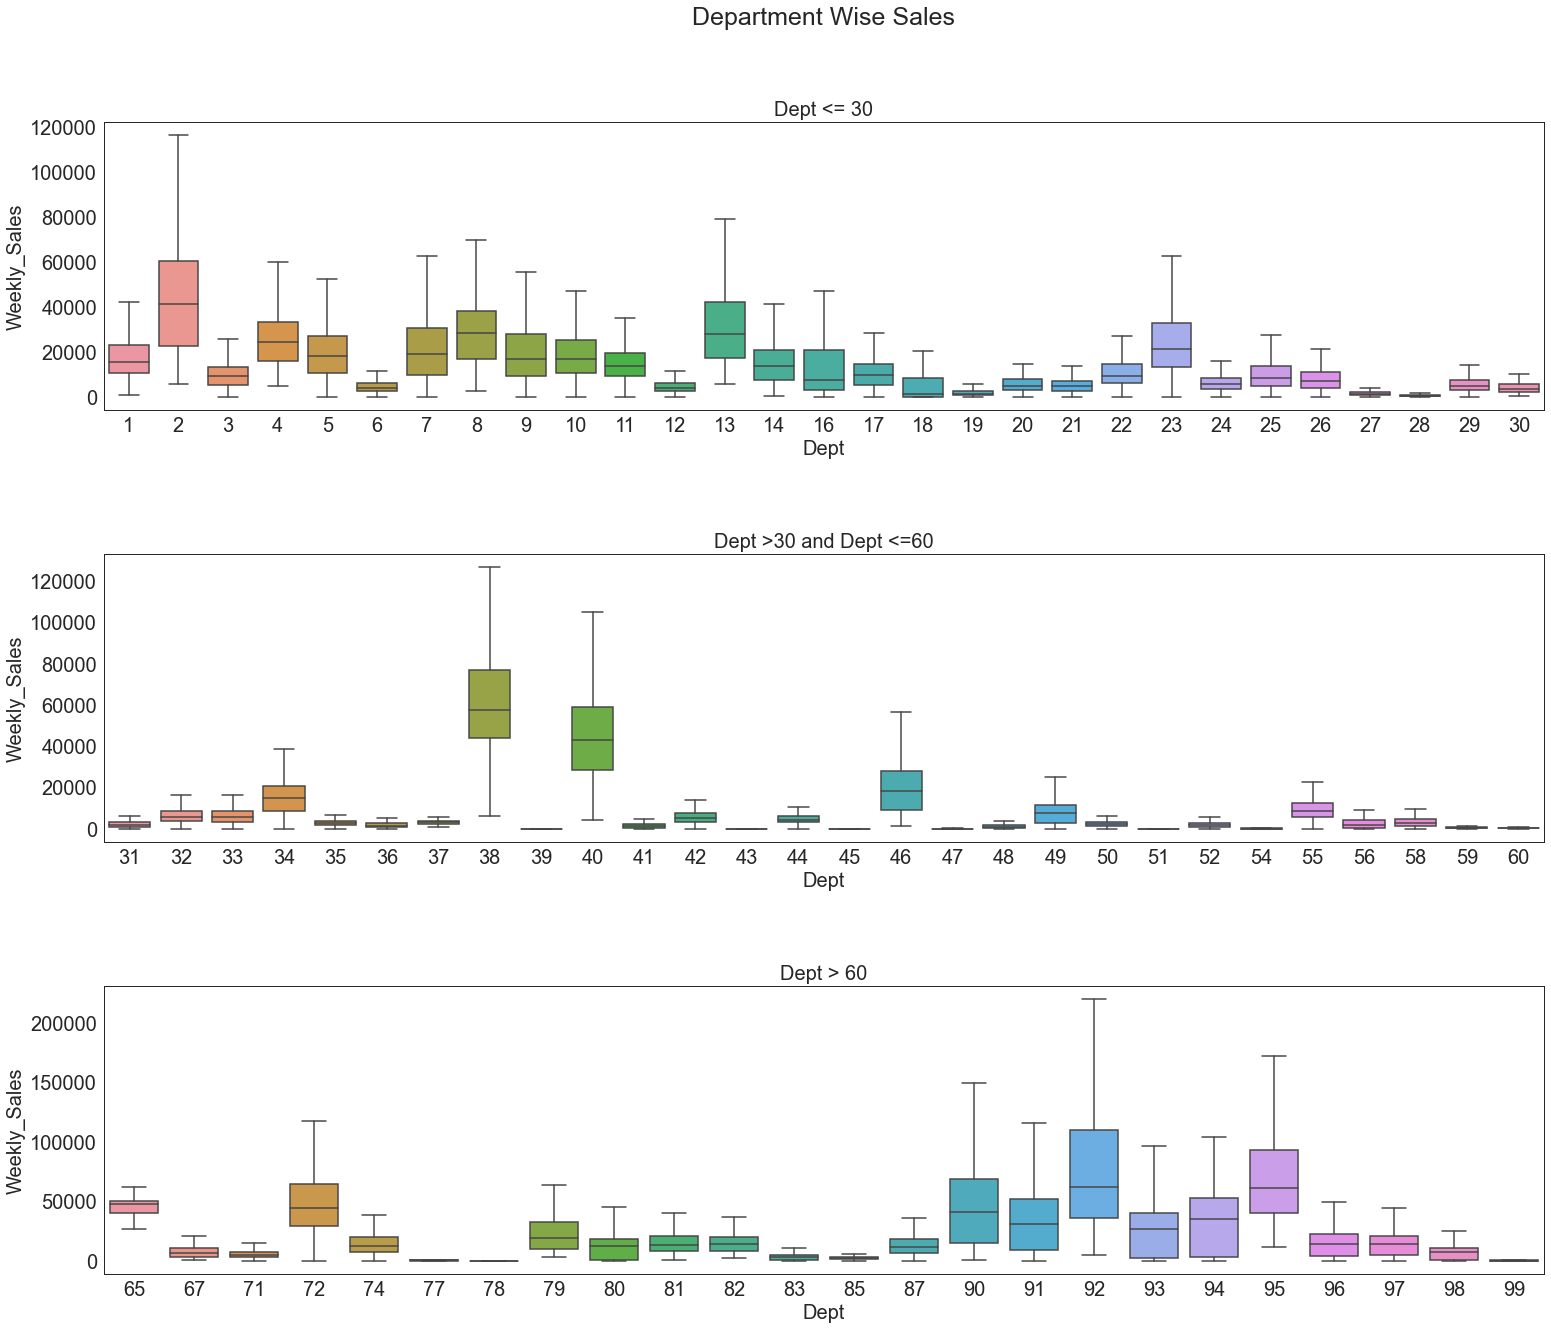

In [86]:
a=df_wal.query('Dept <= 30' )
b=df_wal.query('Dept >30 and Dept <=60')
c=df_wal.query('Dept > 60')
fig,axes = plt.subplots(3,1,figsize=(25,20)) 
fig.suptitle('Department Wise Sales',fontsize=25)

fig.subplots_adjust(wspace=0.5,hspace=0.5)
fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
### subplot for Dept<30
sns.boxplot(x=a['Dept'],y=a['Weekly_Sales'],showfliers=False,ax=axes[0])
axes[0].set_title('Dept <= 30',fontsize=20)
axes[0].set_xlabel('Dept',fontsize=20)
axes[0].set_ylabel('Weekly_Sales',fontsize=20)
axes[0].tick_params(labelsize=20)

### Dept >30 and Dept <=60
sns.boxplot(x=b['Dept'],y=b['Weekly_Sales'],showfliers=False,ax=axes[1])
axes[1].set_title('Dept >30 and Dept <=60',fontsize=20)
axes[1].set_xlabel('Dept',fontsize=20)
axes[1].set_ylabel('Weekly_Sales',fontsize=20)
axes[1].tick_params(labelsize=20)

### Dept >60
sns.boxplot(x=c['Dept'],y=c['Weekly_Sales'],showfliers=False,ax=axes[2])
axes[2].set_title('Dept > 60',fontsize=20)
axes[2].set_xlabel('Dept',fontsize=20)
axes[2].set_ylabel('Weekly_Sales',fontsize=20)
axes[2].tick_params(labelsize=20)


From this box plot we can see department 2,38,40,92 and 95 has greater mean sales comparated to other departments which shows that these department have more useful products for the customer.People are more likely to buy products from these departments.
Department 72,7,5 we can observe high sales during few weeks which is farther away from their mean sales.There is a posibility that these departments supply customers with products which are needed during Holiday Weeks.

In [52]:
df_wal[df_wal['Weekly_Sales']==df_wal['Weekly_Sales'].max()]

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature(C),Fuel_Price($USD/L),MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,LaborsDay,Thanksgiving,Christmas,Easter
90645,10,72,2010-11-26,693099.36,Thanksgiving,55.33,3.162,9951.747,5513.104706,3745.007674,...,4660.451778,126.669267,9.003,B,126512,False,False,True,False,False


In [53]:
df_wal[df_wal['Weekly_Sales']==df_wal['Weekly_Sales'].min()].head(5)

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature(C),Fuel_Price($USD/L),MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,LaborsDay,Thanksgiving,Christmas,Easter
188,1,47,2010-02-19,0.0,No_Holiday,39.93,2.514,8536.592778,3346.401918,1670.797978,...,4428.307667,211.289143,8.106,A,151315,False,False,False,False,False
406,1,47,2010-03-12,0.0,No_Holiday,57.79,2.667,8536.592778,3346.401918,1670.797978,...,4428.307667,211.380643,8.106,A,151315,False,False,False,False,False
2549,1,47,2010-10-08,0.0,No_Holiday,63.93,2.633,8536.592778,3346.401918,1670.797978,...,4428.307667,211.746754,7.838,A,151315,False,False,False,False,False
3632,1,54,2011-01-21,0.0,No_Holiday,44.04,3.016,8536.592778,3346.401918,1670.797978,...,4428.307667,211.827234,7.742,A,151315,False,False,False,False,False
4132,1,47,2011-03-11,0.0,No_Holiday,53.56,3.459,8536.592778,3346.401918,1670.797978,...,4428.307667,214.111056,7.742,A,151315,False,False,False,False,False


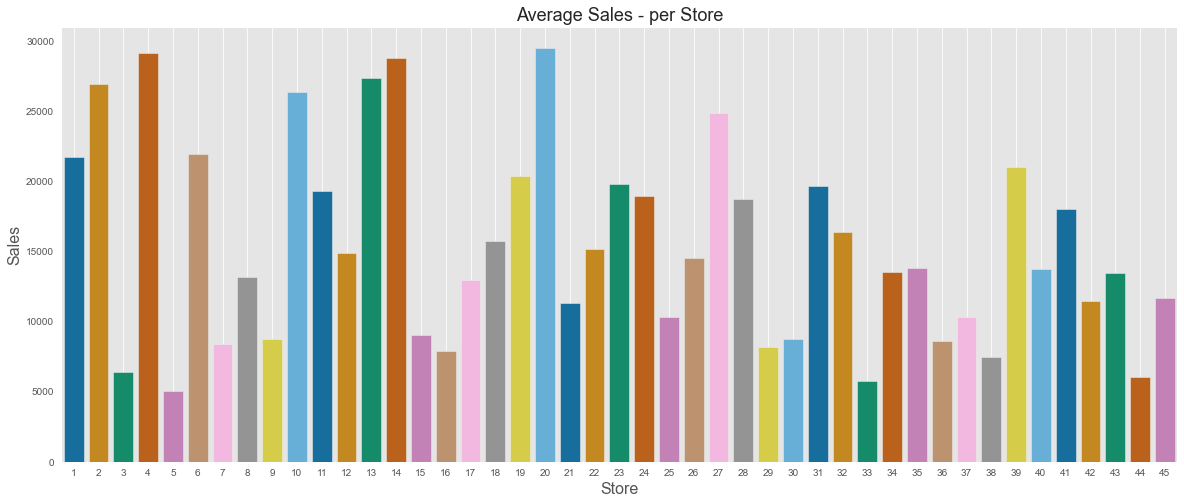

In [55]:
weekly_sales = df_wal['Weekly_Sales'].groupby(df_wal['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='colorblind')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

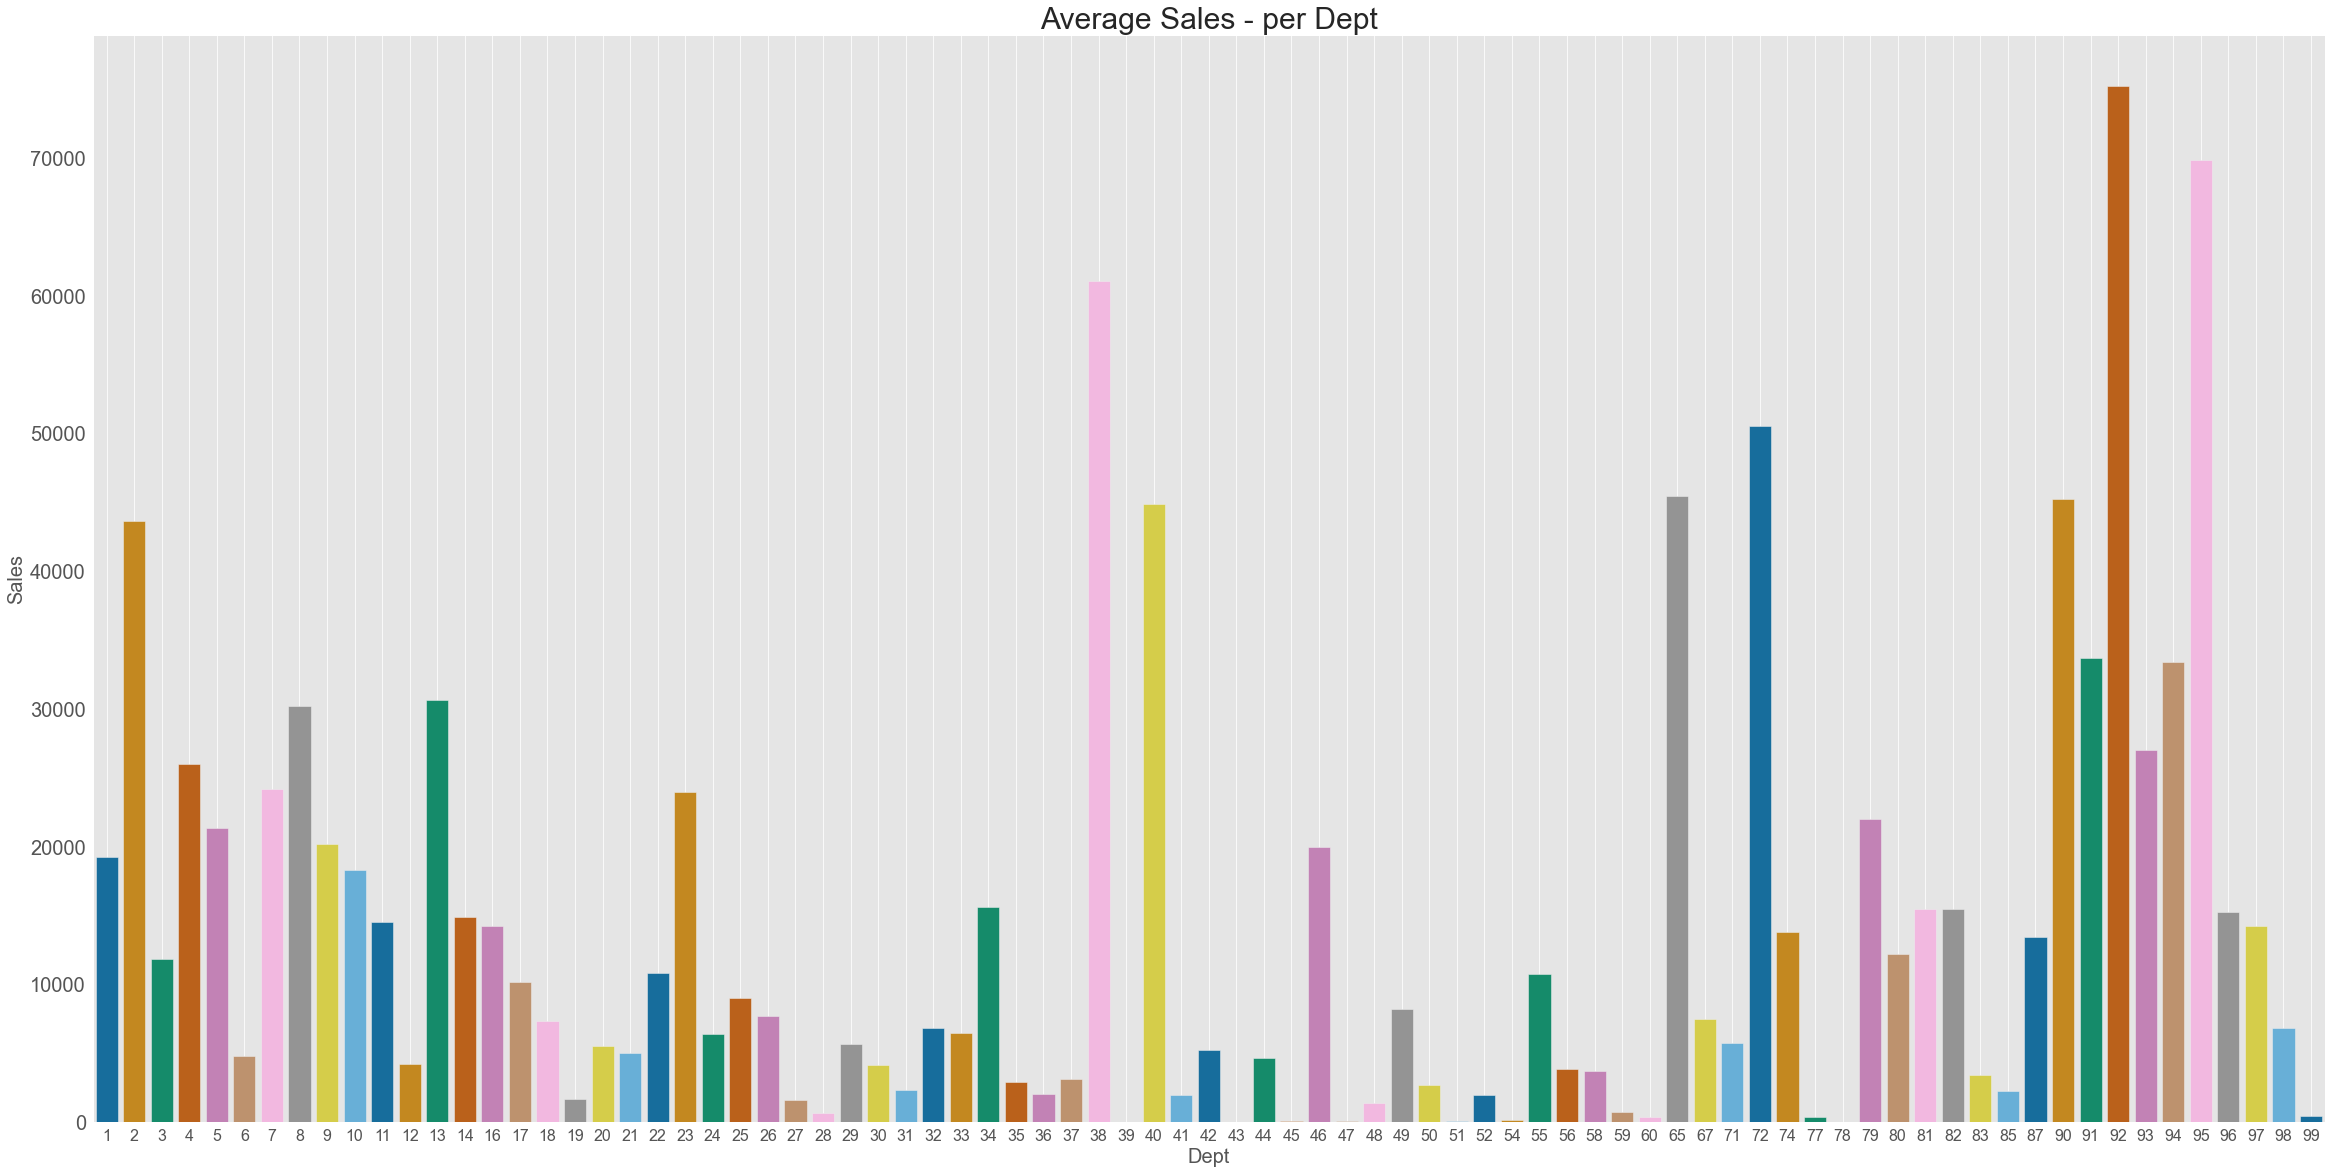

In [56]:
weekly_sales = df_wal['Weekly_Sales'].groupby(df_wal['Dept']).mean()
plt.figure(figsize=(40,20))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='colorblind')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=30)
plt.ylabel('Sales', fontsize=20)
plt.xlabel('Dept', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.show()

In [57]:
df_wal["Date"] = pd.to_datetime(df_wal["Date"]) # convert to datetime
df_wal['week'] =df_wal['Date'].dt.week
df_wal['month'] =df_wal['Date'].dt.month 
df_wal['year'] =df_wal['Date'].dt.year

In [58]:
df_wal.groupby('week')['Weekly_Sales'].mean()

week
1     14862.287625
2     14030.771037
3     14080.485131
4     13530.147104
5     16029.611259
6     16378.169039
7     16486.494452
8     15136.628247
9     15830.230919
10    15523.843411
11    15443.139442
12    14916.039142
13    15704.449247
14    16547.077783
15    15414.421830
16    15625.019999
17    14837.249714
18    16080.572455
19    15540.384942
20    15453.642769
21    16034.629820
22    16779.810814
23    16509.089544
24    16256.800969
25    15911.324075
26    16296.090487
27    16715.529045
28    15707.072688
29    15497.558784
30    15101.815430
31    16324.918381
32    15949.701450
33    16046.187433
34    15981.011567
35    15812.590797
36    15881.912663
37    14828.947006
38    14517.208153
39    14486.114471
40    15770.819194
41    15076.780414
42    15166.238276
43    15247.760651
44    16049.991764
45    16055.529219
46    15580.426541
47    22221.018981
48    16708.943234
49    18668.915368
50    20416.687491
51    26396.683899
52    14544.070187
Name: W

In [59]:
df_wal.groupby('month')['Weekly_Sales'].mean()

month
1     14126.820957
2     16009.398250
3     15418.159384
4     15650.483663
5     15777.349229
6     16327.087390
7     15862.388149
8     16063.559227
9     15097.037477
10    15244.927436
11    17491.891775
12    19356.702443
Name: Weekly_Sales, dtype: float64

In [60]:
df_wal.groupby('year')['Weekly_Sales'].mean()

year
2010    16270.739943
2011    15955.218998
2012    15696.112703
Name: Weekly_Sales, dtype: float64

In [61]:
monthly_sales = pd.pivot_table(df_wal, values = "Weekly_Sales", columns = "year", index = "month")

<AxesSubplot:xlabel='month'>

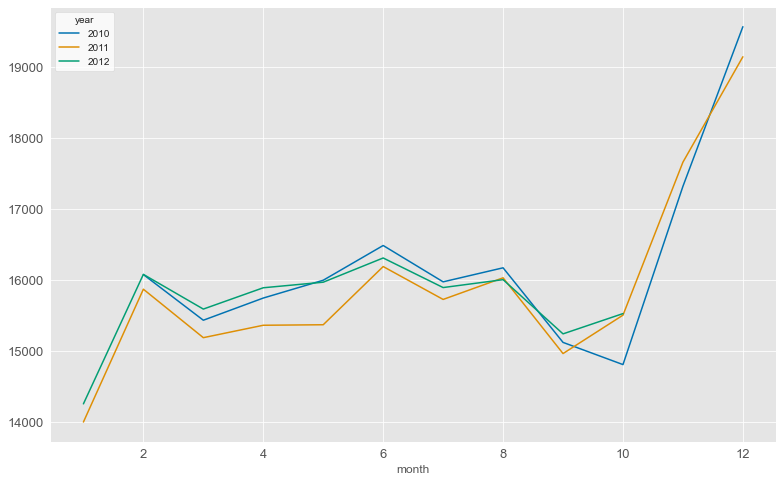

In [62]:
plt.figure(figsize=(13,8))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.set_style("white")
sns.lineplot(data=monthly_sales,dashes=False,palette='colorblind')

Observations

From this line graph, there is peak sale during the last two months which could be due to Christmas and Thanksgiving being the major holidays in America

<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

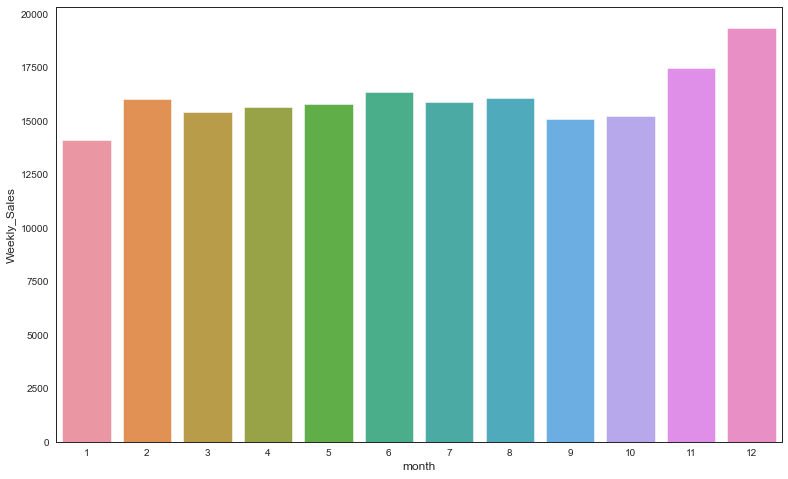

In [63]:
plt.figure(figsize=(13,8))
sns.barplot(x='month', y='Weekly_Sales', data=df_wal,ci=None)

In [64]:
df_wal.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head(5)

week
51    26396.683899
47    22221.018981
50    20416.687491
49    18668.915368
22    16779.810814
Name: Weekly_Sales, dtype: float64

In [65]:
weekly_sales = pd.pivot_table(df_wal, values = "Weekly_Sales", columns = "year", index = "week")

<AxesSubplot:xlabel='week'>

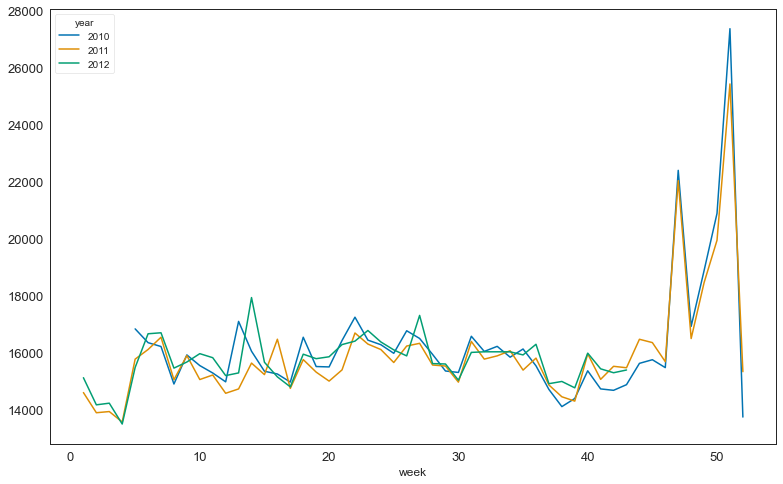

In [66]:
plt.figure(figsize=(13,8))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.set_style("white")
sns.lineplot(data=weekly_sales,dashes=False,palette='colorblind')

<AxesSubplot:xlabel='week', ylabel='Weekly_Sales'>

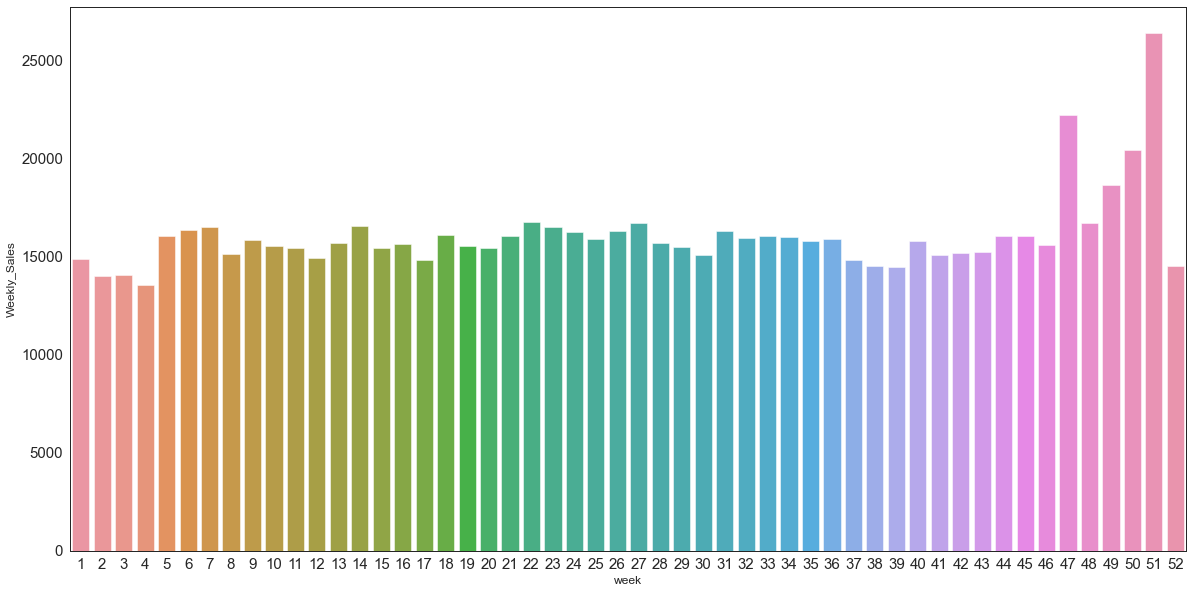

In [67]:
plt.figure(figsize=(20,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.barplot(x='week', y='Weekly_Sales', data=df_wal,ci=None)

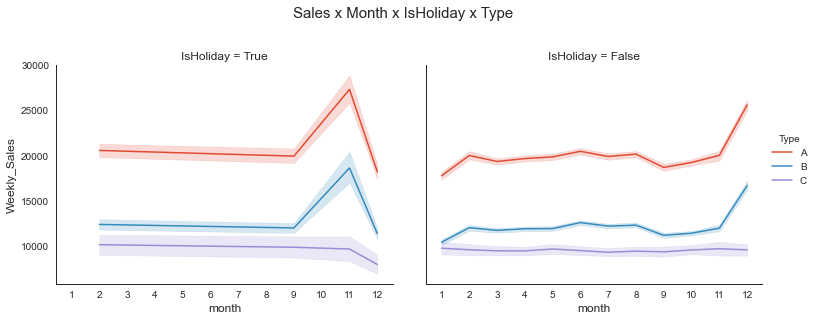

In [95]:
## Month*Holiday*Type - Box plot
g = sns.FacetGrid(df_wal,col='IsHoliday',col_order=[True,False],hue='Type',hue_order=['A','B','C'],
                 aspect=1.2,size=4.5)
g.map(sns.lineplot,'month','Weekly_Sales')
g.set(xticks=np.arange(1,13))
fig = g.fig
fig.suptitle('Weekly Sales for Holiday and No Holiday',size=15)
fig.subplots_adjust(top=0.8,wspace=0.1)
l = g.add_legend(title='Type')

During the holidays, there is peak in sales for the last two months for the stores A and B(the bigger stores)

In [98]:
df_wal['quater'] = df_wal['Date'].dt.quarter   

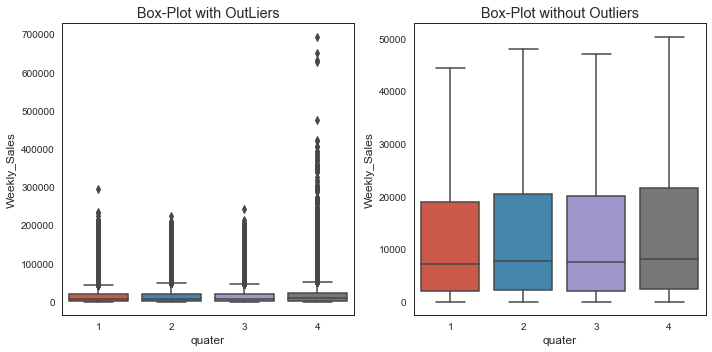

In [99]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=df_wal,x='quater',y='Weekly_Sales',)
plt.title("Box-Plot with OutLiers")
plt.subplot(1,2,2)
sns.boxplot(data=df_wal,x='quater',y='Weekly_Sales',showfliers=False)
plt.title('Box-Plot without Outliers')
plt.tight_layout()

The average weekly sales is the same accross all four quarters. The last quarter has a peak in sale in some week as the max sale for the last quarter is the highest. 

# Fuel Price, CPI , Unemployment , Temperature Effects

<AxesSubplot:xlabel='Fuel_Price($USD/L)', ylabel='Weekly_Sales'>

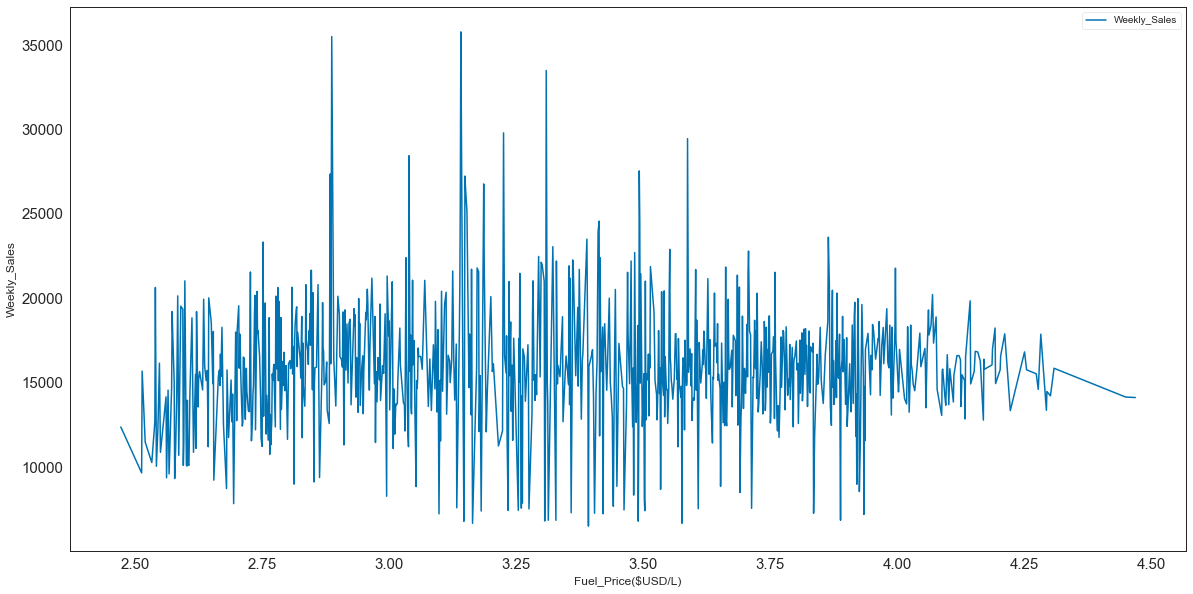

In [68]:
fuel_price = pd.pivot_table(df_wal, values = "Weekly_Sales", index= "Fuel_Price($USD/L)")
plt.figure(figsize=(20,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Weekly_Sales')
sns.lineplot(data=fuel_price, palette='colorblind')

<AxesSubplot:xlabel='CPI', ylabel='Weekly_Sales'>

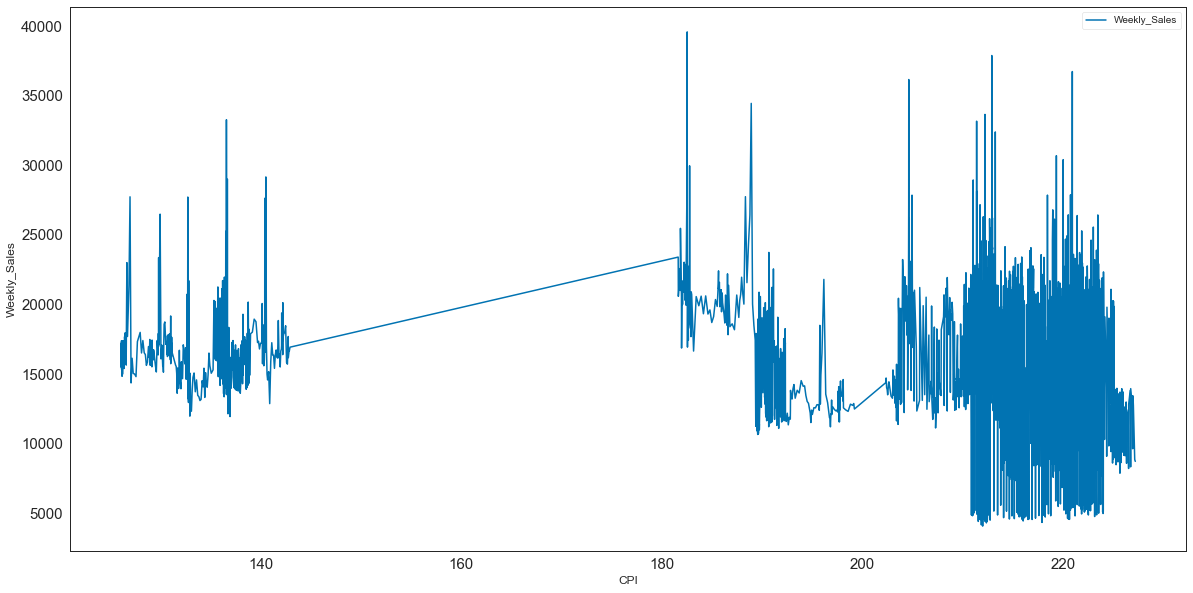

In [69]:
cpi=pd.pivot_table(df_wal, values='Weekly_Sales', index='CPI')
plt.figure(figsize=(20,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Weekly_Sales')
sns.lineplot(data=cpi, palette='colorblind')


<AxesSubplot:xlabel='Unemployment', ylabel='Weekly_Sales'>

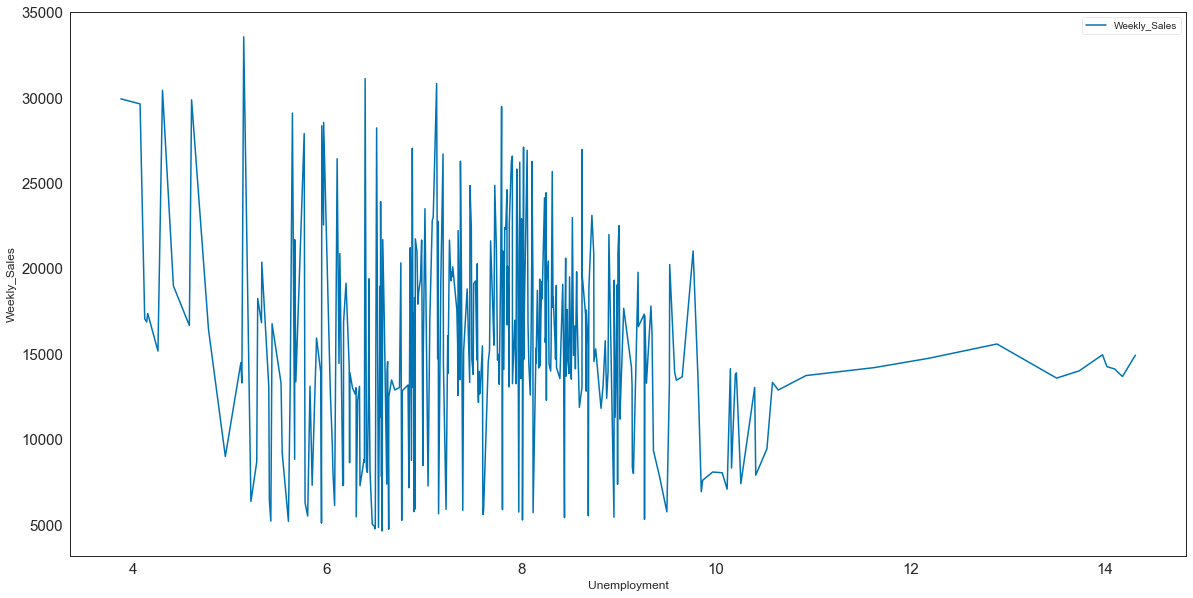

In [70]:
Unemployment=pd.pivot_table(df_wal, values='Weekly_Sales', index='Unemployment')
plt.figure(figsize=(20,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Weekly_Sales')
sns.lineplot(data=Unemployment,palette='colorblind')

<AxesSubplot:xlabel='Temperature(C)', ylabel='Weekly_Sales'>

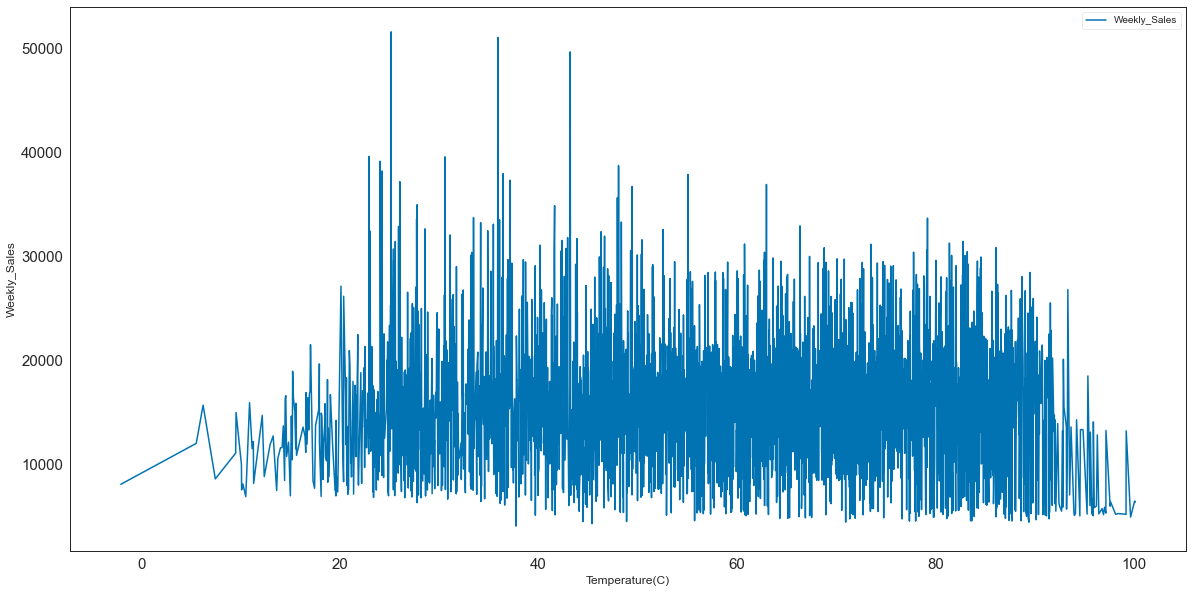

In [71]:
Temperature=pd.pivot_table(df_wal, values='Weekly_Sales', index='Temperature(C)')
plt.figure(figsize=(20,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Weekly_Sales')
sns.lineplot(data=Temperature,palette='colorblind')

There isn't any strong correlation between weekly sales and  CPI, Unemployment rate, Temperature(C) and Fuel Price

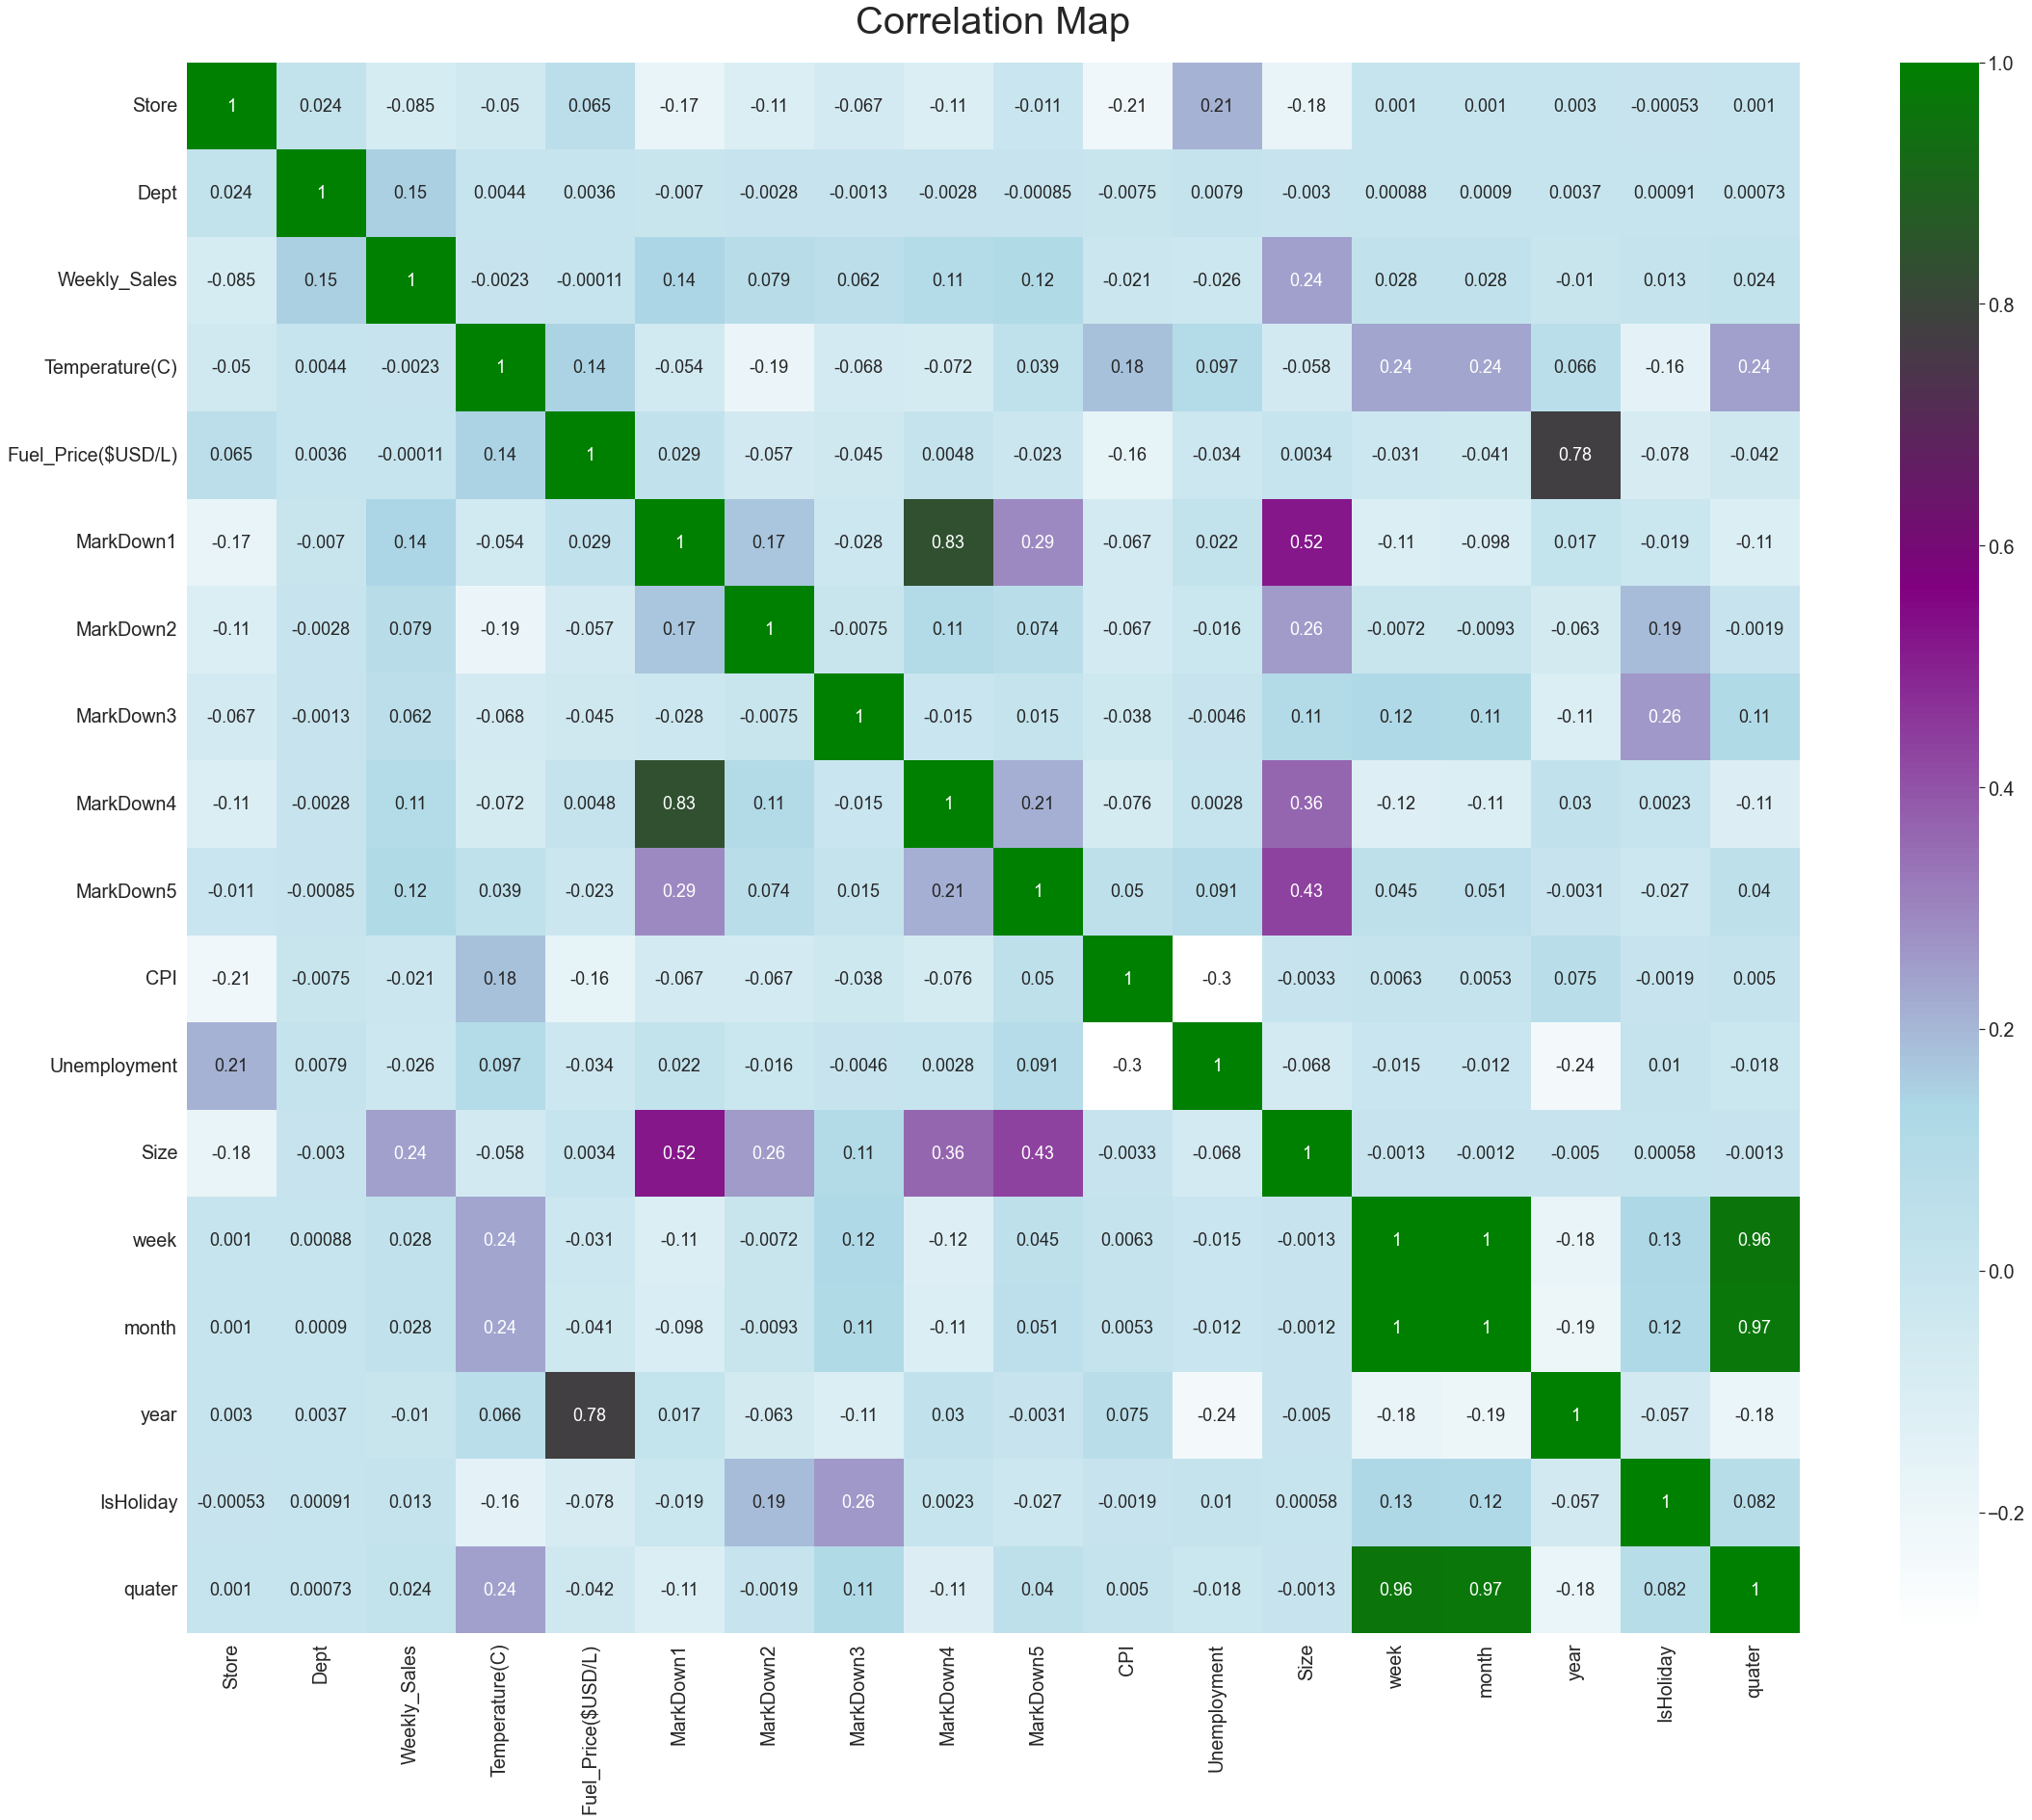

In [109]:
fig = plt.figure(figsize=(25,20))
sns.set(font_scale=1.8)
cmap = sns.blend_palette(colors=['White','lightblue','purple','green'],n_colors=4,as_cmap=True)
ssn = sns.heatmap(df_wal.corr(),annot=True,annot_kws={'fontsize':18},cmap=cmap)
plt.title("Correlation Map",fontdict={'size':40},pad=30)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)  # scale current size by 1.5
plt.show()

Fuel Price, Unemployment, Temperature, and CPI have very weak relation with weekly_sales. 